In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Get the collection of n(=1)-sentence snippets with the word 'love'
love_snippets = pd.read_pickle('./data/processed/love_snippets')

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [3]:
love_snippets.loc[[132, 2382]]

,transcript,url,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,12.0,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,15.0,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [4]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [5]:
# Topic modeling
# Vectorize
tfidf1 = TfidfVectorizer(stop_words='english', lowercase=True,binary=True)
doc_words_tfidf1 = tfidf1.fit_transform(love_snippets.love)

# Dimension Reduction
tfidf_lsa=[]
tfidf_doc_topic=[]
for i in range(2,7):
    tfidf_lsa.append(TruncatedSVD(i))
    tfidf_doc_topic.append(tfidf_lsa[i-2].fit_transform(doc_words_tfidf1))
    print(int(i),'topics variance ratios:',tfidf_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.00568486 0.00852864]
3 topics variance ratios: [0.00568496 0.00852851 0.0056091 ]
4 topics variance ratios: [0.00568496 0.00852806 0.00560389 0.00452776]
5 topics variance ratios: [0.00568489 0.00852846 0.00558773 0.00452343 0.004468  ]
6 topics variance ratios: [0.00568493 0.00852801 0.00560783 0.0045442  0.00448944 0.00400865]


# The 2-Topic Result

In [6]:
display_topics(tfidf_lsa[0], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, thirds, mythology, puzzle, wires, vodka, labor, imagining, phrase, action


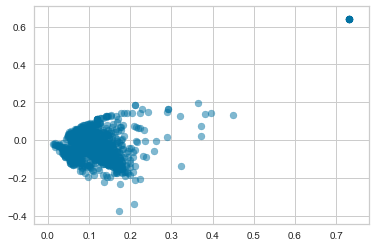

In [7]:
plt.scatter(tfidf_doc_topic[0][:,0],tfidf_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

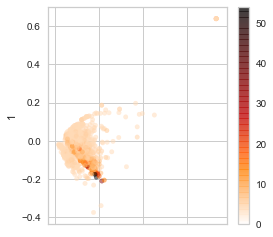

In [8]:
df=pd.DataFrame(tfidf_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

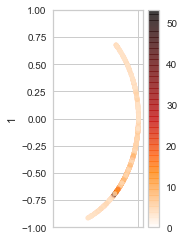

In [9]:
df = pd.DataFrame(normalize(tfidf_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

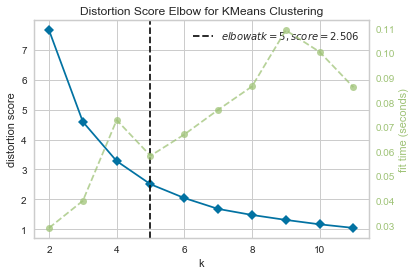

In [10]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(tfidf_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [11]:
visualizer.elbow_value_

5

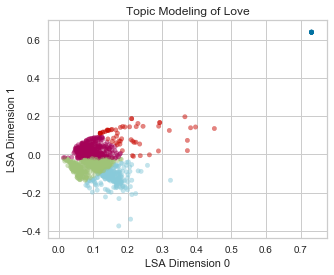

In [12]:
df=pd.DataFrame(tfidf_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [13]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [0.20929377 0.10155276]
g [ 0.09440122 -0.05955676]
b [0.73172765 0.63890991]
c [ 0.1555166  -0.12251818]
m [0.09409404 0.01614019]


Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [14]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,tfidf_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.190149,0.055208,0.925403,0.045510,0.107655
1,0.139987,0.069505,0.880839,0.094487,0.076333
2,0.110445,0.096822,0.859087,0.159000,0.033195
3,0.207005,0.022465,0.951275,0.065800,0.095285
4,0.271177,0.142511,0.974584,0.055343,0.206420


Show the snippets from the 4 (euclidean distance) closest documents:

In [15]:
doc_topic = tfidf_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.20929377 0.10155276] color= r
129 : [0.20940426 0.07671433] I love that kind of stuff.
665 : [0.21409463 0.06891362] Let's say you're in love.
1116 : [0.18222739 0.08139296] And I thought: I love this country.
831 : [0.21838042 0.06222913] We know nothing about love, we know nothing about death, we know nothing about why we're here.


Cluster centered at: [ 0.09440122 -0.05955676] color= g
143 : [ 0.09570501 -0.05881036] Fermi then went on with the same blunt logic to disprove fairies, Sasquatch, God, the possibility of love — and thereafter, as you know, Enrico Fermi ate alone. I loved her, and then she went out into that strange, alien land. And even though, I think you'll agree, it is probable that during the time she was away, she was kidnapped and replaced by an alien clone, I love her and wait for her still.
325 : [ 0.09095252 -0.05859538] But what I love — and I'm a journalist — and what I love is finding hidden patterns; I love being a data detective. An

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

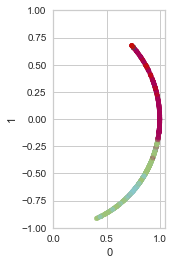

In [16]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [17]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.20929377 0.10155276] color= r
537 : [0.07882658 0.03851331] We love back-of-envelope calculations. I love renewables. (Laughter)So here's a summary so far: All renewables, much as I love them, are diffuse.
370 : [0.08882575 0.04267527] We're all "I Love Lucy" on a great assembly line of information, and we can't keep up.
953 : [0.12223283 0.0603535 ] But I love it for a totally different reason.
135 : [0.07326374 0.0366808 ] And I took my bike into the bike store— I love this — same bike, and they'd do something called "truing" the wheels.


Cluster centered at: [ 0.09440122 -0.05955676] color= g
719 : [ 0.10678969 -0.06757098] And unlike the pink elephant vase, this was a kind of love at first sight. So I loved, on an art historical level, I loved that layered quality that he has. But more than that, I love him. I love his orange and pink breeches. I love the fact that he seems to be going off to war, having just finished the washing up. I love his pink little 

Now clustering on the 

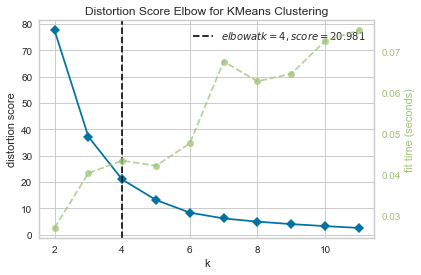

In [18]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

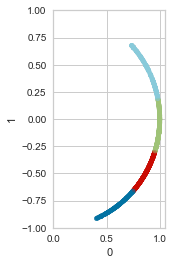

In [19]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [20]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.86257878 -0.49260339] color= r
442 : [ 0.86865625 -0.49541531] As you remember, Cindy Gallop said men don't know the difference between making love and doing porn. The only people who should care about this is parents of boys and girls, educators, gamers, filmmakers and women who would like a real man who they can talk to, who can dance, who can make love slowly and contribute to the evolutionary pressures to keep our species above banana slugs.
766 : [ 0.86900555 -0.49480234] But sometimes a father's love can be misconstrued as controlling, and conversely, the scope of his son's ambition can seem like some pie-in-the-sky fantasy. to the world ♪♪ I hope that someone gets my ♪♪ I hope that someone gets my ♪♪ I hope that someone gets my ♪♪ Message in a bottle ♪♪ Message in a bottle ♪♪ A year has passed since I wrote my note ♪♪ I should have known this right from the start ♪♪ Only hope can keep me together ♪♪ Love can mend your life ♪♪ but love can break your hear

# The 3-topic Result

In [21]:
display_topics(tfidf_lsa[1], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, wires, puzzle, mythology, vodka, thirds, labor, imagining, phrase, action

Topic  2
loved, really, love, ones, family, place, concert, machine, told, cook, iphone, big, lost, sailing


In [22]:
tfidf_doc_topic[1]

array([[ 0.14646784, -0.07800459,  0.03734259],
       [ 0.15635627, -0.0275884 , -0.04602102],
       [ 0.12264916,  0.03310355, -0.02312806],
       ...,
       [ 0.11307273,  0.0400565 , -0.00916608],
       [ 0.09657788, -0.02317009, -0.05900283],
       [ 0.13771289,  0.02605197, -0.0101022 ]])

In [23]:
from mpl_toolkits.mplot3d import Axes3D

In [24]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(tfidf_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

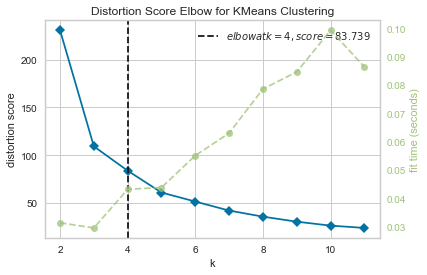

In [25]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [26]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


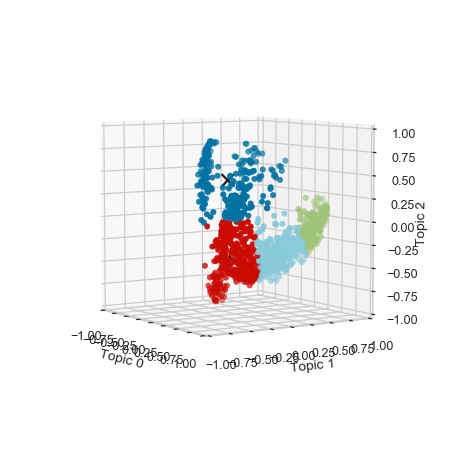

In [30]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=100,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

So, what do the clusters mean?

In [31]:
doc_topic = tfidf_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.74620243 -0.49916448 -0.34647852] color= r
1106 : [ 0.78082872 -0.52001733 -0.34624915] But it's an inside job, and we can't arrange peace or lasting improvement for the people we love most in the world. (Laughter)When William Blake said that we are here to learn to endure the beams of love, he knew that your family would be an intimate part of this, even as you want to run screaming for your cute little life. The mystery of grace is that God loves Henry Kissinger and Vladimir Putin and me exactly as much as He or She loves your new grandchild. And I was surprised, but they said I could give a talk, and I said I'd love to.
1087 : [ 0.79819872 -0.49443576 -0.34411056] you know, we fell in love with science when we were kids, and yet we somehow spend most of our time during high school and college just jumping through hoops and doing things so that we can polish our résumé instead of sitting down and reflecting on what we want to do and who we want to be. But whe

## DBSCAN Clustering

In [32]:
from sklearn.cluster import DBSCAN

In [33]:
db = DBSCAN(eps=0.055, min_samples=5).fit(df)
labels = db.labels_
np.unique(labels,return_counts=True)
# labels = hdbscan.HDBSCAN(
#     min_samples=10,
#     min_cluster_size=500,
# ).fit_predict(clusterable_embedding)

(array([-1,  0,  1,  2,  3,  4,  5,  6]),
 array([100, 867,  97,  43,   6,  11,  11,   7]))

In [34]:
cmap = {-1: 'k', 0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow',10:'fuchsia',11:'purple',12:'brown'}
col = pd.DataFrame(np.array([db.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


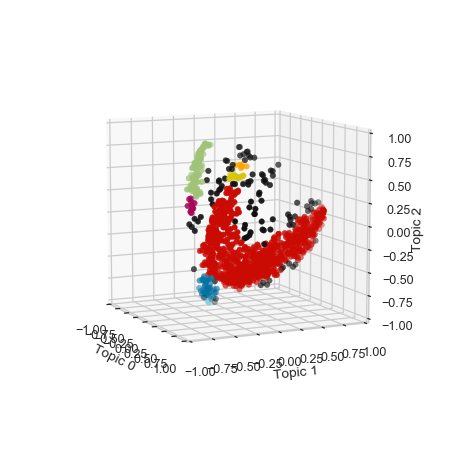

In [36]:
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=100,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## MeanShift Clustering

In [37]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [38]:
# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(df, quantile=0.09)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df)
cluster_centers = ms.cluster_centers_
np.unique(ms.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([410, 187, 213, 116,  59,  52, 105]))

<IPython.core.display.Javascript object>


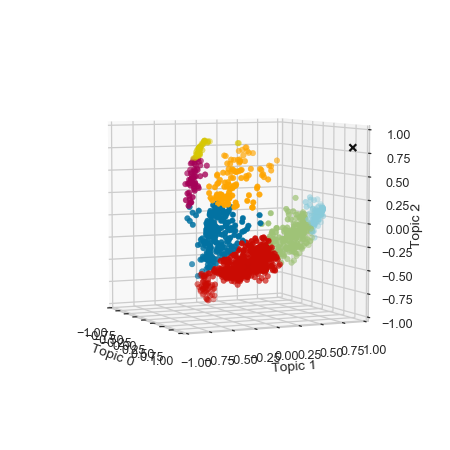

In [39]:
col = pd.DataFrame(np.array([ms.labels_])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## Hierarchical clustering

In [40]:
from sklearn.cluster import AgglomerativeClustering

In [41]:
# linkage can be 'ward', 'average' or 'complete'
hc = AgglomerativeClustering(linkage='average', n_clusters=6)
hc.fit(df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=6,
                        pooling_func='deprecated')

<IPython.core.display.Javascript object>


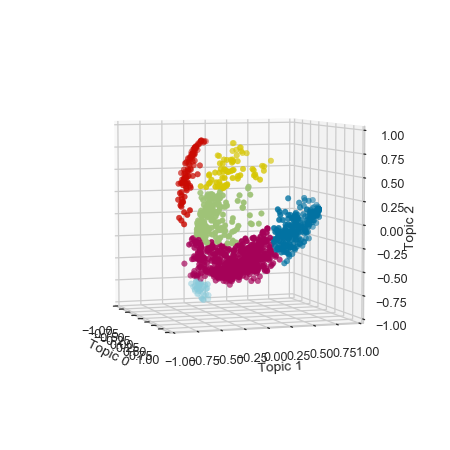

In [42]:
col = pd.DataFrame(np.array([hc.labels_])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## Spectral Clustering

In [43]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=6)
labels = sc.fit_predict(df)

<IPython.core.display.Javascript object>


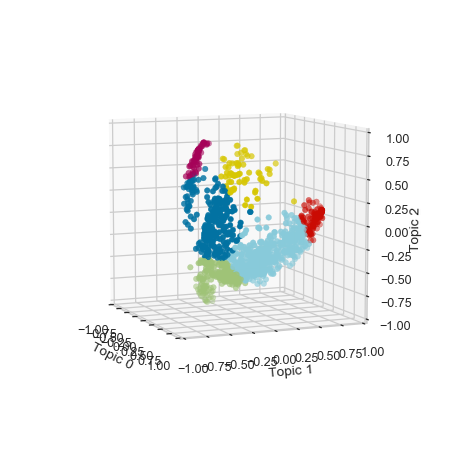

In [44]:
col = pd.DataFrame(np.array([labels])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

# The 4-Topic Result

In [45]:
display_topics(tfidf_lsa[2], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, wires, thirds, vodka, mythology, puzzle, labor, imagining, phrase, action

Topic  2
loved, really, love, ones, family, place, concert, machine, told, cook, big, iphone, sailing, lost

Topic  3
laughter, picture, lovely, applause, right, make, loved, got, idea, told, internet, basically, little, true


In [46]:
doc_topic = tfidf_doc_topic[2]
df = pd.DataFrame(normalize(tfidf_doc_topic[2]))

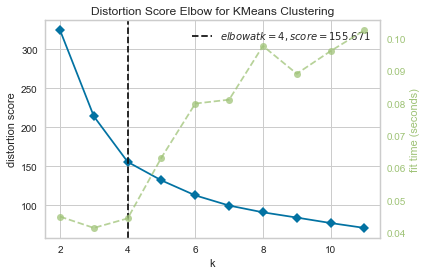

In [47]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [48]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


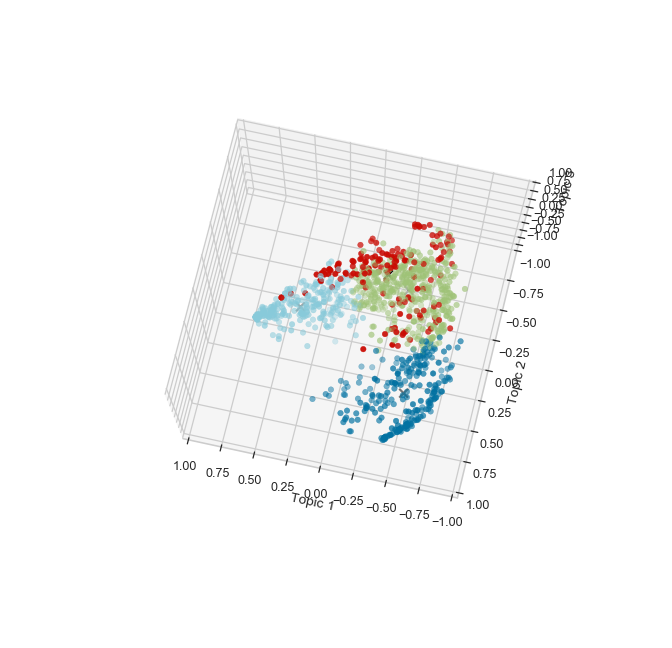

In [49]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=50,c='k')
ax.scatter(df[1],df[2],df[3],c=col)
ax.set_xlabel('Topic 1')
ax.set_ylabel('Topic 2')
ax.set_zlabel('Topic 3')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

In [50]:
doc_topic = tfidf_doc_topic[2]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.59367743 -0.20649657 -0.23349118  0.60887656] color= r
1028 : [ 0.63842133 -0.21503761 -0.2697097   0.68806519] I love what I do, but I love my kids more. "(Laughter)So my activation button for gay equality was pressed, and along with many, many others, I campaigned for years for gay rights, and in particular, the right to marry the person that I love. And in 2014, on the day that the law was changed, I married my wife, who I love very much, indeed. Love triumphs. I love to gather inspirational stories from the past and pass them on.
985 : [ 0.6624009  -0.23164094 -0.29687613  0.64763577] A few years ago, I rounded up a bunch of Muslim-American comedians — in a non-violent way —(Laughter)And we went around the country to places like Alabama, Arizona, Tennessee, Georgia — places where they love the Muzzies — and we did stand-up shows.
552 : [ 0.67857939 -0.24220256 -0.29871092  0.62581125] So one of the features that I think is important about our work is that o